# Uso de series del BCRA en API Series de Tiempo

<h1>Indice<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Uso-de-series-del-BCRA-en-API-Series-de-Tiempo" data-toc-modified-id="Uso-de-series-del-BCRA-en-API-Series-de-Tiempo-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Uso de series del BCRA en API Series de Tiempo</a></span></li><li><span><a href="#Resumen-ejecutivo" data-toc-modified-id="Resumen-ejecutivo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Resumen ejecutivo</a></span><ul class="toc-item"><li><span><a href="#Llamadas-mensuales---Año-2018" data-toc-modified-id="Llamadas-mensuales---Año-2018-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Llamadas mensuales - Año 2018</a></span></li><li><span><a href="#Números-generales" data-toc-modified-id="Números-generales-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Números generales</a></span><ul class="toc-item"><li><span><a href="#Sobre-las-consultas" data-toc-modified-id="Sobre-las-consultas-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Sobre las consultas</a></span></li><li><span><a href="#Sobre-los-usuarios" data-toc-modified-id="Sobre-los-usuarios-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Sobre los usuarios</a></span></li><li><span><a href="#Series-populares" data-toc-modified-id="Series-populares-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Series populares</a></span></li></ul></li></ul></li><li><span><a href="#Cantidad-de-llamadas" data-toc-modified-id="Cantidad-de-llamadas-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Cantidad de llamadas</a></span><ul class="toc-item"><li><span><a href="#Perfil-de-las-series-del-BCRA" data-toc-modified-id="Perfil-de-las-series-del-BCRA-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Perfil de las series del BCRA</a></span><ul class="toc-item"><li><span><a href="#Perfil-de-series-diarias-del-BCRA" data-toc-modified-id="Perfil-de-series-diarias-del-BCRA-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Perfil de series diarias del BCRA</a></span></li></ul></li></ul></li><li><span><a href="#Cantidad-de-usuarios" data-toc-modified-id="Cantidad-de-usuarios-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cantidad de usuarios</a></span><ul class="toc-item"><li><span><a href="#Comportamiento-de-usuarios-segmentados-por-tipo-de-consumo" data-toc-modified-id="Comportamiento-de-usuarios-segmentados-por-tipo-de-consumo-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Comportamiento de usuarios segmentados por tipo de consumo</a></span><ul class="toc-item"><li><span><a href="#Descripción-de-la-variables" data-toc-modified-id="Descripción-de-la-variables-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Descripción de la variables</a></span></li><li><span><a href="#Segmentación-para-el-período-completo" data-toc-modified-id="Segmentación-para-el-período-completo-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Segmentación para el período completo</a></span></li></ul></li></ul></li></ul></div>

In [1]:
# Carga y normalización de analytics

In [2]:
## Setup

In [3]:
import sys
import os
import locale

import re
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from urllib.parse import parse_qs

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import maxabs_scale, minmax_scale, MinMaxScaler
from sklearn.cluster import KMeans
import squarify

locale.setlocale(locale.LC_ALL, '')

%matplotlib inline

sns.set()
plt.rcParams['image.cmap'] = 'Accent'

pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', -1)
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: locale.format_string('%d', x, 1))


In [4]:
## Funciones auxiliares

In [183]:
# formarters
f_ar = lambda x: locale.format_string('%.2f', x, 1)
d_ar = lambda x: locale.format_string('%d', x, 1)

tz_arg = lambda x: pd.to_datetime(x).tz_localize('UTC').tz_convert(tz='America/Argentina/Buenos_Aires')

TABLE_COUNTER = 0
TABLE_TEMPLATE = """
<center><strong><small>{title}</small></strong></center>
<center>{table}</center>
<center><strong><small>Tabla {table_number}</small></strong></center>
"""
    
def table_counter():
    global TABLE_COUNTER
    TABLE_COUNTER += 1
    return TABLE_COUNTER

def add_style_to_df(df, subset, color='black', font_weight=None):
    render = df.style.set_properties(
        subset= subset, 
        **{'font-weight': font_weight, 'color':color}).render().replace('\n','')
    return render

def add_title(df_html, title):
    str_table = TABLE_TEMPLATE.format(title=title, table=df_html, table_number=table_counter())
    return str_table.replace('\n','')

def put_df_on_report(df, title, subset=None, color='black', font_weight='bold'):
    if subset:
        df_html = add_style_to_df(df, subset=subset,color=color, font_weight=font_weight)
    else:
        df_html = df.to_html().replace('\n','')
    return add_title(df_html, title)

In [6]:
midpoint = lambda x: (np.max(x)+ np.min(x))/2
log_midpoint = lambda x: np.power(10,((np.log10(np.max(x))+np.log10(np.min(x)))/2))

def read_files_to_df(directory):
    """Lee CSVs de misma estructura en un directorio a un solo DataFrame."""

    file_pattern = os.path.join(directory, "*.csv")
    dfs = [pd.read_csv(file, encoding="utf8", parse_dates=True)
           for file in glob.glob(file_pattern)]
        
    return pd.concat(dfs, axis=0)

def parse_ids(qs):
    if pd.notna(qs):
        if 'ids' in qs:
            params = parse_qs(qs)
            ids_values_str = params.get('ids',[''])[0]
        else:
            ids_values_str = qs

        return [value.split(':')[0] for value in ids_values_str.split(',')]
    else:
        return []

def iter_series_ids(df):
    for analytic_id, id_list in zip(df.id, df.ids):
            if isinstance(id_list, list):
                for serie_id in id_list:
                    yield (analytic_id, serie_id)
    
def unfold_series_id(df):
    list_ids = []
    for analytic_id, serie_id in iter_series_ids(df):
        list_ids.append([analytic_id, serie_id])
        
    df_ids = pd.DataFrame(list_ids, columns=['analytic_id','serie_id'])
    df_ids.dropna(inplace=True)
    
    df_ids['analytic_id'] = df_ids['analytic_id'].astype(object)
    
    df_extended = df_ids.merge(df, left_on='analytic_id', right_on='id')
    df_extended = df_extended.drop(columns=['analytic_id'])
    
    return df_extended

def replace_and_drop_column(df, old_column, new_column):
    df[new_column] = df[old_column]
    new_df = df.drop(old_column, axis=1)
    return new_df

def add_totals(df):
    df_to_append = pd.DataFrame(df.sum(numeric_only=True)).T
    
    df_appended = df.append(df_to_append)
    
    as_list = df_appended.index.tolist()
    idx = as_list.index(0)
    as_list[idx] = 'Total'
    df_appended.index = as_list
    
    return df_appended

def add_linear_regression(df, target_col, index_as_feature=True, feature_cols=''):
    if index_as_feature:
        X = df.index.values.reshape(-1, 1)
    else:
        n_r, n_c = df[feature_cols].shape
        X = df[feature_cols].values.reshape(-1, n_c)
        
    y = df[target_col].values
    
    reg = LinearRegression()
    reg.fit(X, y)
    
#     df['linear_regression'] = 
    return reg.predict(X)

#
def interpolate_by_days(df, column, date_col='' ,days=1, floor=0):
    df['day_factor'] = pd.DatetimeIndex(df[date_col]).dayofyear % days
    day_factor_unique = df.day_factor.unique()
    list_df = []

    call_col_inter = column + '_inter'
    
    for day_factor in day_factor_unique:
#         for call_col in columns:
        
        filter_by_df = df.day_factor == day_factor
        df_f = df[filter_by_df]
        df_f[call_col_inter] = df_f[column].apply(lambda x: np.nan if x < floor else x)
        df_f.loc[:,call_col_inter] = df_f[call_col_inter].interpolate(method='linear', limit_direction='both',inplace=False)
        list_df.append(df_f)
        del df_f

    df_inter = pd.concat(list_df, sort=True)
    
    return df_inter[call_col_inter]

In [7]:
# para retención de usr
def get_week(d):
    start = d - pd.Timedelta(days=d.weekday())
    end = start + pd.Timedelta(days=6)
    return end

def cohort_period(df):
    df['cohort_period'] = np.arange(len(df)) + 1
    return df

In [8]:
# para clusterizar
# recibe un unfolded
def get_nunique_series_avg(df, frequency='W'):
    """Devuelve el promedio de cantidad de series únicas por la frencuencia indicada """
    df_list = []
    
    for frequency in 'DWM':
        if frequency is 'D':
            col = 'date'
            frec_col = 'series_unicas_diarias'
        elif frequency is 'W':
            col = 'weekofyear'
            frec_col = 'series_unicas_semanales'
        elif frequency is 'M':
            col = 'month'
            frec_col = 'series_unicas_mensuales'
        else:
            return
        
        df_avg_series = df.groupby(['ip_address',col]).nunique()['serie_id'].reset_index()
        
#         n_series_unicas = df_avg_series.serie_id.count()
        
        df_avg_series = df_avg_series[['ip_address', 'serie_id']].groupby('ip_address').mean()
        df_avg_series.rename({'serie_id':frec_col},axis=1, inplace=True) 
                
        df_list.append(df_avg_series)

    df_series_avg = pd.concat(df_list, axis=1).reset_index()
    
    ass = df[['month','ip_address', 'serie_id','indice_tiempo_frecuencia']].drop_duplicates()
    id_unicos_por_ip_mes = ass.groupby(['ip_address','month']).nunique()['serie_id'].reset_index()
    
    serie_diaria = ass.indice_tiempo_frecuencia.str.contains('R/P1D')
    id_diarios_unicos_por_ip_mes = ass[serie_diaria].groupby(['ip_address','month']).nunique()['serie_id'].reset_index()
    
#     ### ip - month - su - sud
#     ass = df[['date_short','ip_address', 'serie_id','indice_tiempo_frecuencia']].drop_duplicates()
#     id_unicos_por_ip_mes = ass.groupby(['ip_address','date_short']).nunique()['serie_id'].reset_index()
#     id_unicos_por_ip_mes.rename({'serie_id':'series_unicas'}, axis=1, inplace=True)
#     serie_diaria = ass.indice_tiempo_frecuencia.str.contains('R/P1D')
#     id_diarios_unicos_por_ip_mes = ass[serie_diaria].groupby(['ip_address','date_short']).nunique()['serie_id'].reset_index()
#     id_diarios_unicos_por_ip_mes.rename({'serie_id':'series_diarias_unicas'}, axis=1, inplace=True)

#     #n_id_diarios_unicos = id_diarios_unicos_por_ip_mes.groupby('ip_address').mean().reset_index()
#     asss = id_unicos_por_ip_mes.merge(id_diarios_unicos_por_ip_mes, on=['ip_address','date_short'], how='left').fillna(0)

#     ####
#     assss = asss[['ip_address','series_unicas','series_diarias_unicas']].groupby('ip_address').mean()

    ### ip - su - sud
    ass = df[['ip_address', 'serie_id','indice_tiempo_frecuencia']].drop_duplicates()
    id_unicos_por_ip_mes = ass.groupby('ip_address').nunique()['serie_id'].reset_index()
    id_unicos_por_ip_mes.rename({'serie_id':'series_unicas'}, axis=1, inplace=True)
    serie_diaria = ass.indice_tiempo_frecuencia.str.contains('R/P1D')
    id_diarios_unicos_por_ip_mes = ass[serie_diaria].groupby('ip_address').nunique()['serie_id'].reset_index()
    id_diarios_unicos_por_ip_mes.rename({'serie_id':'series_diarias_unicas'}, axis=1, inplace=True)

    #n_id_diarios_unicos = id_diarios_unicos_por_ip_mes.groupby('ip_address').mean().reset_index()
    asss = id_unicos_por_ip_mes.merge(id_diarios_unicos_por_ip_mes, on='ip_address', how='left').fillna(0)

    ####
    assss = asss

    df_series_avg = df_series_avg.merge(assss, on='ip_address').fillna(0)

    return df_series_avg


# recibe un unfolded!
def get_ips_calls_max(df, frequency='D'):
    """Devuelve el promedio diario de llamadas por IP """
    if frequency is 'W':
        df_ncalls = df.groupby(['ip_address','weekofyear']).nunique()['id'].reset_index()
    elif frequency is 'D':
        df_ncalls = df.groupby(['ip_address','date']).nunique()['id'].reset_index()
    else:   
        return
    
    df_ncalls = df_ncalls.groupby(['ip_address']).max().reset_index()
    df_ncalls.rename({'id':'max_calls'},axis=1, inplace=True)
    df_ncalls.sort_values('max_calls', ascending=False, inplace=True)

    return df_ncalls

# recibe un unfolded!
def get_ips_calls_count(df, frequency='D'):
    """Devuelve el promedio diario de llamadas por IP """
    if frequency is 'W':
        df_ncalls = df.groupby(['ip_address','weekofyear']).nunique()['id'].reset_index()
    elif frequency is 'D':
        df_ncalls = df.groupby(['ip_address','date']).nunique()['id'].reset_index()
    else:   
        return
    
    df_ncalls = df_ncalls.groupby(['ip_address']).mean().reset_index()
    df_ncalls.rename({'id':'actividad'},axis=1, inplace=True)
    df_ncalls.sort_values('actividad', ascending=False, inplace=True)

    return df_ncalls

# recibe un unfolded!
def get_ips_persistency(df, frequency='W'):
    """Devuelve la proporción de semanas con actividad para cada IP
    Args:
        frequency: str. W o D
    """
    if frequency is 'W':
        group_cols = ['year','month','ip_address']
        data_cols = group_cols + ['weekofyear']

        n_frec = df[['year','month','weekofyear']].groupby(['year','month']).nunique()[['weekofyear']].sum().values[0]

        df_persistency = df[data_cols].groupby(group_cols).nunique()[['weekofyear']]
    elif frequency is 'D':
        group_cols = ['ip_address']
        data_cols = group_cols + ['date']

        n_frec = df.date.nunique()

        df_persistency = df[data_cols].groupby(group_cols).nunique()[['date']]
    else:   
        return
    
    df_persistency = df_persistency.unstack(level=0).unstack(level=0)
    df_persistency = df_persistency.fillna(0).sum(1).reset_index()
    df_persistency.rename({0:'persistencia'},axis=1, inplace=True)
    df_persistency.sort_values('persistencia', ascending=False, inplace=True)
    df_persistency['persistencia'] = df_persistency.persistencia.divide(n_frec/100)

    return df_persistency

# recibe un unfolded!
def get_ip_features(df, frequencies={'persistencia':'W','actividad':'D'}):
    
    df_ncalls = get_ips_calls_count(df, frequency=frequencies['actividad'])
    df_persistency = get_ips_persistency(df, frequency=frequencies['persistencia'])
#     df_maxcalls = get_ips_calls_max(df)

    df_ip_features = df_ncalls.merge(df_persistency, how='inner', on='ip_address')
#     df_ip_features = df_ip_features.merge(df_maxcalls, how='inner', on='ip_address')
    
    return df_ip_features

# 
def cluster_ips(df, n_kmeans=3, frequencies={'persistencia':'W','actividad':'D'},labels=None):
    df_ip_features = get_ip_features(df, frequencies)

    X = df_ip_features[['actividad','persistencia']].values.reshape(-1, 2)
    X_minmax = MinMaxScaler().fit_transform(X)
    
    clusters_id = KMeans(n_kmeans, random_state=0).fit_predict(X_minmax)

    ips_clusterizados = df_ip_features.merge(pd.DataFrame(clusters_id), how='inner', left_index=True, right_index=True)
    ips_clusterizados.rename({0:'cluster_id'}, axis=1, inplace=True)
    ips_clusterizados['cluster_name'] = ips_clusterizados.cluster_id.apply(lambda x: labels[x])
    return ips_clusterizados


In [9]:
## Datos analytics

In [10]:
# Cargo csv's
# df_analytics = read_files_to_df('/home/melik/sdt-analytics-download/')
df_analytics = read_files_to_df('../../../../sdt-analytics-download/')

In [11]:
# Filtro analytics por valores de interés
uri_serie = df_analytics.uri.str.contains('/series/api/series')
status_ok = df_analytics.status_code == 200
status_nan = df_analytics.status_code.isnull()

df_analytics = df_analytics[(uri_serie) & (status_ok | status_nan)]

In [12]:
# Filtro analytics. Saco ip's de test, saco períodos sin datos

# ips asociados al pico del 2018-12-21
test_ips = ['190.16.55.43','190.210.119.109', '190.246.123.181']
# ips asociados al pico del 2018-02-15
test_ips.extend(['195.162.12.14','190.18.52.25'])

exclude_test_ips = ~df_analytics.ip_address.isin(test_ips)
df_analytics = df_analytics[exclude_test_ips]

In [13]:
# Cambio el tipo de dato de la columna 'timestamp' a datetime
df_analytics['start_time_utc'] = pd.to_datetime(df_analytics['start_time'])

df_analytics['start_time'] = pd.DatetimeIndex(df_analytics['start_time']).tz_localize('UTC').tz_convert(tz='America/Argentina/Buenos_Aires')
df_analytics["date"] = pd.DatetimeIndex(df_analytics.start_time).normalize()
df_analytics["hour"] = pd.DatetimeIndex(df_analytics.start_time).hour
df_analytics["month"] = pd.DatetimeIndex(df_analytics.start_time).month
df_analytics["year"] = pd.DatetimeIndex(df_analytics.start_time).year
df_analytics['weekday'] = pd.DatetimeIndex(df_analytics.start_time).weekday
df_analytics['weekofyear'] = pd.DatetimeIndex(df_analytics.start_time).weekofyear
df_analytics['weekdate'] = df_analytics["date"].apply(get_week)
df_analytics['weekdate_short'] = df_analytics.weekdate.dt.strftime("%Y-%m-%d")
df_analytics['date_short'] = pd.DatetimeIndex(df_analytics.date).strftime('%Y-%m')

In [14]:
# Separo las ids de la llamada
df_analytics['ids'] = df_analytics.querystring.apply(parse_ids)

In [15]:
# hay duplicados?
# pd.DataFrame(df_analytics[df_analytics.duplicated(subset='id')].sort_values('id')).to_excel('./analytics_duplicated.xlsx')

In [16]:
# Borro duplicados
df_analytics.drop_duplicates(subset='id', inplace=True)

In [17]:
## Datos de la API

In [18]:
df_serie = pd.read_csv('https://apis.datos.gob.ar/series/api/dump/series-tiempo-metadatos.csv')

In [19]:
# fuentes_bcra_extendido= ['Banco Central de la República Argentina (BCRA)',
#        'Bancos Centrales',
#        'BCRA, MAE, Rofex',]

fuentes_bcra = ['Banco Central de la República Argentina (BCRA)']

serie_bcra = df_serie.dataset_fuente.isin(fuentes_bcra)
df_serie_bcra = df_serie[serie_bcra]
df_serie_no_bcra = df_serie[~serie_bcra]

In [20]:
serie_description = ['serie_id','serie_descripcion','dataset_tema','indice_tiempo_frecuencia']
df_serie_short = df_serie[serie_description]

In [21]:
total_series_bcra = df_serie_bcra.serie_id.nunique()
total_series = df_serie.serie_id.nunique()
str_total_series_bcra = d_ar(total_series_bcra)

percentage_bcra = total_series_bcra/total_series*100
str_percentage_bcra = f_ar(percentage_bcra)



# Resumen ejecutivo

In [22]:
# genero df_unfolded para todo el período
df_unfolded = unfold_series_id(df_analytics)
# del df_analytics

# separo por series bcra, no bcra y total (df para gráfico histórico)
dtype = dict(year=int)
df_unfolded = df_serie[['serie_id']].merge(df_unfolded.astype(dtype),how='inner', on='serie_id')

bcra = df_unfolded.serie_id.isin(df_serie_bcra.serie_id)
no_bcra = df_unfolded.serie_id.isin(df_serie_no_bcra.serie_id)

df_unfolded['serie_fuente'] = 'no_bcra'
df_unfolded.loc[bcra,'serie_fuente'] = 'bcra'

df_calls_full = df_unfolded[['serie_fuente','serie_id','date']].groupby(['date','serie_fuente']).count()
df_calls_full = df_calls_full.unstack(level=-1)

mi = df_calls_full.columns
ind = pd.Index([e[0] +'_'+ e[1] for e in mi.tolist()])
df_calls_full.columns = ind

df_calls_full.rename({'serie_id_bcra':'consultas_bcra', 'serie_id_no_bcra':'consultas_no_bcra'}, axis=1, inplace=1)
df_calls_full['consultas_total'] = df_calls_full.consultas_bcra + df_calls_full.consultas_no_bcra

df_calls_full.reset_index(inplace=True)

# filtro el último trimestre 2018
## start_date = pd.to_datetime('2018-09-30')
start_date = tz_arg('2018-10-01T03:00:00') 
# pd.to_datetime('2018-10-01').tz_localize('UTC').tz_convert(tz='America/Argentina/Buenos_Aires')
exclude_before_date = df_unfolded.start_time > start_date

end_date = tz_arg('2018-12-31T04:00:00')
# pd.to_datetime('2018-12-31').tz_localize('UTC').tz_convert(tz='America/Argentina/Buenos_Aires')
exclude_after_date = df_unfolded.start_time <= end_date

df_unfolded = df_unfolded[exclude_before_date & exclude_after_date]

# genero df_unfolded's
df_unfolded = df_serie.merge(df_unfolded.astype(dtype),how='inner', on='serie_id')

bcra = df_unfolded.serie_id.isin(df_serie_bcra.serie_id)
no_bcra = df_unfolded.serie_id.isin(df_serie_no_bcra.serie_id)

df_bcra_unfolded = df_unfolded[bcra]
df_no_bcra_unfolded = df_unfolded[no_bcra]

In [117]:
# hits
df_hits = df_unfolded[['serie_id','id']].groupby('serie_id').count()
df_hits = df_hits.sort_values('id', ascending=False).reset_index()
df_hits = replace_and_drop_column(df_hits, 'id', 'consultas')

df_hits = df_hits.merge(df_serie_short, how='inner', on='serie_id',sort=False)

hits_bcra = df_hits.serie_id.isin(df_serie_bcra.serie_id)
hits_no_bcra = ~hits_bcra

df_bcra_hits = df_hits[hits_bcra]
df_no_bcra_hits = df_hits[hits_no_bcra]

df_bcra_hits.rename({'indice_tiempo_frecuencia':'frecuencia'},axis=1, inplace=True)
df_no_bcra_hits.rename({'indice_tiempo_frecuencia':'frecuencia'},axis=1, inplace=True)

In [118]:
# ips
df_ips = df_unfolded[['serie_id','ip_address']].groupby('serie_id').nunique()[['ip_address']]
df_ips = df_ips.sort_values('ip_address', ascending=False).reset_index()
df_ips = replace_and_drop_column(df_ips, 'ip_address', 'ip_cantidad')

df_ips = df_ips.merge(df_serie_short, how='inner', on='serie_id',sort=False)

ips_bcra = df_ips.serie_id.isin(df_serie_bcra.serie_id)
ips_no_bcra = ~ips_bcra

df_bcra_ips = df_ips[ips_bcra]
df_no_bcra_ips = df_ips[ips_no_bcra]

df_bcra_ips.rename({'indice_tiempo_frecuencia':'frecuencia'},axis=1, inplace=True)
df_no_bcra_ips.rename({'indice_tiempo_frecuencia':'frecuencia'},axis=1, inplace=True)

In [119]:
# - AGREGAR LÍNEA MENSUAL CON LA CANTIDAD DE LLAMADAS POR MES (INTERPOLANDO LOS HUECOS), PARA TODO 2018
# - CONSIDERAR SOLO EL ÚLTIMO TRIMESTRE

In [120]:
# período 
analytics_dates = df_unfolded.date.sort_values().unique()
analytics_start = str(analytics_dates[0]).split('T')[0][:10]
analytics_end = str(analytics_dates[-1]).split('T')[0][:10]

str_periodo = analytics_start + ' - ' + analytics_end

In [133]:
df_1 = df_serie_bcra.groupby('indice_tiempo_frecuencia').count()[['serie_id']].rename({'serie_id':'series_bcra'}, axis=1)    
df_2 = df_serie_no_bcra.groupby('indice_tiempo_frecuencia').count()[['serie_id']].rename({'serie_id':'series_no_bcra'}, axis=1)

df_series_by_freq = pd.concat([df_1, df_2],axis=1, sort=False)
df_series_by_freq.fillna(0, inplace=True)

df_series_by_freq['proporcion_serie_bcra'] = 100*df_series_by_freq.series_bcra.divide(df_series_by_freq.series_bcra.sum())
df_series_by_freq['proporcion_serie_no_bcra'] = 100*df_series_by_freq.series_no_bcra.divide(df_series_by_freq.series_no_bcra.sum())

df_series_by_freq = add_totals(df_series_by_freq)

df_series_by_freq['proporcion_serie_bcra'] = df_series_by_freq['proporcion_serie_bcra'].apply(lambda x: locale.format_string('%.2f %%', x, 1))
df_series_by_freq['proporcion_serie_no_bcra'] = df_series_by_freq['proporcion_serie_no_bcra'].apply(lambda x: locale.format_string('%.2f %%', x, 1))

In [134]:
# cantidad total de hits a series del BCRA
serie_bcra_total_hits = df_bcra_hits.consultas.sum()
str_serie_bcra_total_hits = d_ar(serie_bcra_total_hits)

# proporción de hits a series del BCRA sobre el total de hits
bcra_hits_in_total = df_bcra_hits.consultas.sum()/df_hits.consultas.sum()*100
str_bcra_hits_in_total = f_ar(bcra_hits_in_total)

# cantidad de hits por serie del BCRA
hits_top_5 = df_bcra_hits.head()
hits_last_5 = df_bcra_hits.tail()

percentage_top_5 = hits_top_5.consultas.sum()/serie_bcra_total_hits*100
str_percentage_top_5 = f_ar(percentage_top_5)

# cantidad de hits por frecuencia de serie BCRA vs no-BCRA
df_1 = df_bcra_hits.groupby('frecuencia').sum()[['consultas']].rename({'consultas':'consultas_bcra'}, axis=1)
df_2 = df_no_bcra_hits.groupby('frecuencia').sum()[['consultas']].rename({'consultas':'consultas_no_bcra'}, axis=1)
df_hits_by_freq = pd.concat([df_1, df_2],axis=1, sort=False).fillna(0)

df_hits_by_freq = add_totals(df_hits_by_freq)

df_hits_by_freq['consultas_por_serie_bcra'] = (df_hits_by_freq.consultas_bcra / df_series_by_freq.series_bcra).fillna(0)
df_hits_by_freq['consultas_por_serie_no_bcra'] = (df_hits_by_freq.consultas_no_bcra / df_series_by_freq.series_no_bcra).fillna(0)

df_hits_by_freq['consultas_por_serie_bcra'] = df_hits_by_freq['consultas_por_serie_bcra'].apply(lambda x: locale.format_string('%.2f', x, 1))
df_hits_by_freq['consultas_por_serie_no_bcra'] = df_hits_by_freq['consultas_por_serie_no_bcra'].apply(lambda x: locale.format_string('%.2f', x, 1))

str_calls_frec_diaria_bcra = d_ar(df_hits_by_freq.loc['R/P1D','consultas_bcra'])

str_perc_frec_diaria_bcra = f_ar(df_hits_by_freq.loc['R/P1D','consultas_bcra']/df_hits_by_freq.loc[:,'consultas_bcra'].sum()*100)

str_calls_by_frec_diaria_bcra = d_ar(df_hits_by_freq.loc['R/P1D','consultas_bcra']/df_series_by_freq.loc['R/P1D','series_bcra'].sum())



In [136]:
maxs = df_bcra_hits[['frecuencia','consultas']].groupby('frecuencia').max()

maxs_bcra = maxs.merge(df_bcra_hits, how='inner', on=['consultas','frecuencia'])
maxs_bcra = maxs_bcra.set_index('frecuencia')
maxs_bcra = maxs_bcra.rename(index={'frecuencia':''})
maxs_bcra.index.name = None
maxs_bcra = maxs_bcra[['serie_id','consultas','serie_descripcion','dataset_tema']]

In [137]:
series_call_by_week_avg = df_bcra_unfolded[['date']].resample('7D',on='date').count().mean().values[0]
series_call_by_week_median = df_bcra_unfolded[['date']].resample('7D',on='date').count().median().values[0]

df_weekly = pd.DataFrame([series_call_by_week_avg, series_call_by_week_median]).T
df_weekly.rename({0:'promedio', 1: 'mediana'}, axis=1, inplace=True)

as_list = df_weekly.index.tolist()
idx = as_list.index(0)
as_list[idx] = 'por semana'
df_weekly.index = as_list


series_calls_by_day_avg = df_bcra_unfolded[['serie_id','date']].groupby(['date']).count().mean().values[0]
series_calls_by_day_median = df_bcra_unfolded[['serie_id','date']].groupby(['date']).count().median().values[0]

str_series_calls_by_day_avg = f_ar(series_calls_by_day_avg)

df_daily = pd.DataFrame([series_calls_by_day_avg, series_calls_by_day_median]).T
df_daily.rename({0:'promedio', 1: 'mediana'}, axis=1, inplace=True)

as_list = df_daily.index.tolist()
idx = as_list.index(0)
as_list[idx] = 'por día'
df_daily.index = as_list

df_avg_median = df_daily.append(df_weekly)
df_avg_median = df_avg_median[['promedio']]


In [138]:
# sobre los usuarios
# cantidad de ips por serie del BCRA
ips_top_5 = df_bcra_ips.head()
ips_last_5 = df_bcra_ips.tail()

# serie con más ips
str_serie_top_1 = ips_top_5.iloc[0,2]
str_serie_top_2 = ips_top_5.iloc[1,2]
str_serie_top_3 = ips_top_5.iloc[2,2]

# cantidad de ips para todas las series del BCRA
total_ips = df_unfolded.ip_address.nunique();
bcra_total_ips = df_bcra_unfolded.ip_address.nunique();
no_bcra_total_ips = df_no_bcra_unfolded.ip_address.nunique();
str_bcra_total_ips = d_ar(bcra_total_ips)

# proporción de ips para las series del BCRA sobre el total
bcra_ips_in_total = bcra_total_ips/total_ips*100
str_bcra_ips_in_total = f_ar(bcra_ips_in_total)

# cantidad de ips por frecuencia de serie BCRA vs no-BCRA
df_bcra_ip_by_frec = df_bcra_unfolded[['ip_address','indice_tiempo_frecuencia']].groupby('indice_tiempo_frecuencia').nunique()[['ip_address']].rename({'ip_address':'bcra_ip_cantidad'}, axis=1)
df_no_bcra_ip_by_frec = df_no_bcra_unfolded[['ip_address','indice_tiempo_frecuencia']].groupby('indice_tiempo_frecuencia').nunique()[['ip_address']].rename({'ip_address':'no_bcra_ip_cantidad'}, axis=1)
df_ips_by_freq = pd.concat([df_bcra_ip_by_frec, df_no_bcra_ip_by_frec],axis=1, sort=False).fillna(0)



# df_ips_by_freq = add_totals(df_ips_by_freq)

En la base de la API de Series de tiempo hay {{str_total_series_bcra}} series cuya fuente primaria es el Banco Central de la República Argentina (BCRA) ({{str_percentage_bcra}}% del total de series disponibles). 
- Reciben un promedio de {{str_series_calls_by_day_avg}} consultas por día ({{str_bcra_hits_in_total}}% del total de consultas a la API).

- Fueron consultadas por {{str_bcra_total_ips}} usuarios identificados ({{str_bcra_ips_in_total}}% del total).


Esto implica que casi el total de usuarios de la API consumen por lo menos una serie del BCRA, en el transcurso de su trabajo cotidiano con datos de coyuntura.

## Llamadas mensuales - Año 2018 

En Noviembre se evidencia un salto en la cantidad de llamadas. Esto se debe a que a principios de ese mes el sitio web del Ministerio de Hacienda comenzó a utilizar la API como fuente de datos para sus gráficos

In [139]:
df_calls_full_date = df_calls_full.resample('D', on='date').sum().reset_index().copy()

filter_calls = df_calls_full_date.columns.str.contains('s_bcra') | df_calls_full_date.columns.str.contains('tota')
calls_columns = df_calls_full_date.columns[filter_calls]

df_calls_full_date['consultas_bcra_inter'] = interpolate_by_days(df_calls_full_date, # df_calls_by_day_count
                                            column= 'consultas_bcra', 
                                            date_col='date',
                                            days=42,
                                            floor=750);

df_calls_full_date['consultas_total_inter'] = interpolate_by_days(df_calls_full_date,
                                            column= 'consultas_total', 
                                            date_col='date',
                                            days=42,
                                            floor=8000);

df_calls_full_date.loc[:,'propocion_inter'] = df_calls_full_date.consultas_bcra_inter.divide(df_calls_full_date.consultas_total_inter)*100

df_calls_full_month = df_calls_full_date.resample('M', on='date').agg({'consultas_bcra_inter': pd.Series.sum,
                                                       'propocion_inter': pd.Series.mean}).copy()# sum()
df_calls_full_month.reset_index(inplace=True)

# saco 2019
df_calls_full_tx = df_calls_full_month.iloc[:-2,:].copy()

# acorto date
df_calls_full_tx.loc[:,'date'] = df_calls_full_month.date.apply(pd.datetime.strftime,args=['%Y-%m'])
df_calls_full_tx.reset_index(inplace=True)

# df_calls_full_tx['tendencia'] = add_linear_regression(df_calls_full_tx, 'consultas_bcra_inter')

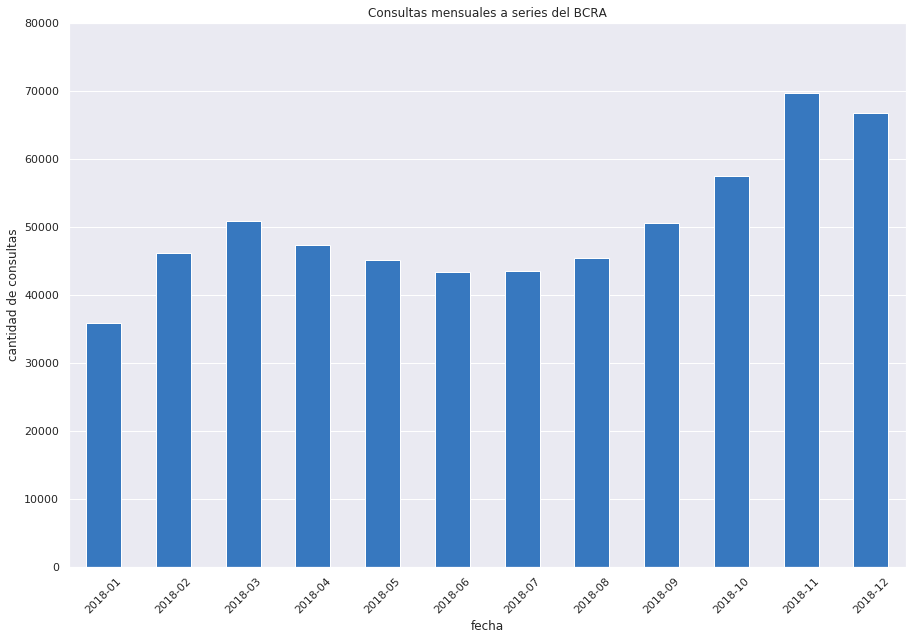

In [140]:
n_row, n_col = df_calls_full_tx.shape
scatter_color = np.array([sns.xkcd_rgb["windows blue"] for _ in range(n_row)])

fig, ax = plt.subplots(figsize=(15,10))

# df_calls_full_tx.plot.scatter(x='index', y='consultas_bcra_inter',ax=ax,legend=True, s=99, c=scatter_color);
df_calls_full_tx.plot.bar(x='date',y='consultas_bcra_inter',ax=ax,legend=False, color=sns.xkcd_palette(["windows blue"]));
# df_calls_full_tx.plot.line(y='tendencia',ax=ax,legend=True, lw=2, alpha=.4, style='--');

ax.set_ylim(0,80000)
ax.set_ylabel('cantidad de consultas BCRA')
plt.grid(axis='x')

# ax2 = ax.twinx()
# df_calls_full_tx.plot.scatter(x='index', y='propocion_inter',ax=ax2,legend=True, s=99, c='green');
# df_calls_full_tx.plot.line(x='date',y='propocion_inter',ax=ax2,legend=True, lw=3, c='green');

# ax2.set_ylabel('cantidad de consultas totales')
# ax2.set_ylim(0,800000)

plt.xticks(df_calls_full_tx.index, df_calls_full_tx.date, rotation=45)
# plt.legend(fontsize=15)

plt.title('Consultas mensuales a series del BCRA')
plt.ylabel('cantidad de consultas')
plt.xlabel('fecha');

## Números generales

La mayor cantidad de series del BCRA en la API de Series de Tiempo son de frecuencia mensual, mientras que en el resto de las fuentes primarias el promedio de frecuencia de actualización es un poco más bajo.

In [143]:
str_df_series_by_freq = put_df_on_report(df_series_by_freq,title='Series disponibles en la API, por frecuencia')

{{str_df_series_by_freq}}


### Sobre las consultas 

Las series diarias del BCRA son consultadas mucho más intensamemnte que las series de otras frecuencias, y mucho más intensamente que las series de frecuencia diaria del resto de las fuentes primarias.


En el período considerado ({{str_periodo}}), las series diarias del BCRA recibieron el {{str_perc_frec_diaria_bcra}}% de las consultas a series del BCRA. Esto hace que en promedio, cada serie diaria haya sido consultada {{str_calls_by_frec_diaria_bcra}} veces.

In [153]:
str_df_hits_by_freq = put_df_on_report(df_hits_by_freq,title='Consultas a series por fuente y frecuencia')

{{str_df_hits_by_freq}}

Las cinco series del BCRA más consultadas, reúnen el {{str_percentage_top_5}}% de consultas totales realizadas a series del BCRA: 

In [145]:
str_hits_top_5 = put_df_on_report(hits_top_5,title='Series del BCRA más consultadas')

{{str_hits_top_5}}

### Sobre los usuarios

El {{str_bcra_ips_in_total}}% de los usuarios de la API Series de Tiempo consultan series del BCRA.<br>
En el período {{str_periodo}}, la cantidad de usuarios fue de {{str_bcra_total_ips}}

Cuando vemos la popularidad de las series por cantidad de usuarios, en vez de por cantidad de llamadas, la lista de las series más populares cambia, mostrando que el grueso de los usuarios consulta la serie *{{str_serie_top_1}}*, seguidas de *{{str_serie_top_2}}* y *{{str_serie_top_3}}*:

In [146]:
str_ips_top_5 = put_df_on_report(ips_top_5,title='Series del BCRA con más usuarios')

{{str_ips_top_5}}

In [154]:
df_ips_by_freq.loc['Total ips únicos',:] = [bcra_total_ips, no_bcra_total_ips]

df_ips_by_freq['bcra_ip_cantidad'] = df_ips_by_freq['bcra_ip_cantidad'].apply(lambda x: locale.format_string('%d', x, 1))

En forma similar a como ocurre con la cantidad de llamadas a series de distintas frecuencias, vemos que las series diarias y mensuales tienen una base de usuarios mucho más amplia que las otras frecuencias:

In [161]:
str_df_ips_by_freq = put_df_on_report(df_ips_by_freq,title='Cantidad de usuarios de la API por fuente y frecuencia')

{{str_df_ips_by_freq}}

### Series populares 

El siguiente gráfico muestra la cantidad de usuarios por cantidad de llamadas, para cada serie del BCRA. <br>

Se trazan líneas auxiliares en la media de cada eje, y se sombrea el área que contiene a las series más consultadas y con mayor cantidad de usuarios.

In [169]:
df_hits_ips = df_bcra_hits[['serie_id','consultas']].merge(df_bcra_ips, how='inner' ,on='serie_id')
frec_series = pd.Series(df_hits_ips.frecuencia.unique())

df_hits_ips['frec_id'] = df_hits_ips[['serie_id','frecuencia']].groupby(['frecuencia']).ngroup()
df_hits_ips.rename({'ip_cantidad':'usuarios'}, axis=1,inplace=True)

# df_hits_ips['rank'] = df_hits_ips.consultas.apply(np.log10) * df_hits_ips.ip_cantidad.apply(np.log10)

for c in ['consultas', 'usuarios']:
    c_norm = c + '_norm'
    df_hits_ips[c_norm] = (df_hits_ips[c] - df_hits_ips[c].mean()) / (df_hits_ips[c].max() - df_hits_ips[c].min())

df_hits_ips['rank'] = df_hits_ips.consultas_norm + df_hits_ips.usuarios_norm


X = df_hits_ips.consultas.values.reshape(-1, 1)
Y = df_hits_ips.usuarios.values.reshape(-1, 1)


n_series = 17

top_rank = df_hits_ips.sort_values('rank', ascending=False).head(n_series)
top_rank_short = top_rank.iloc[:,[0,3,5,4,1,2]].reset_index(drop=True)

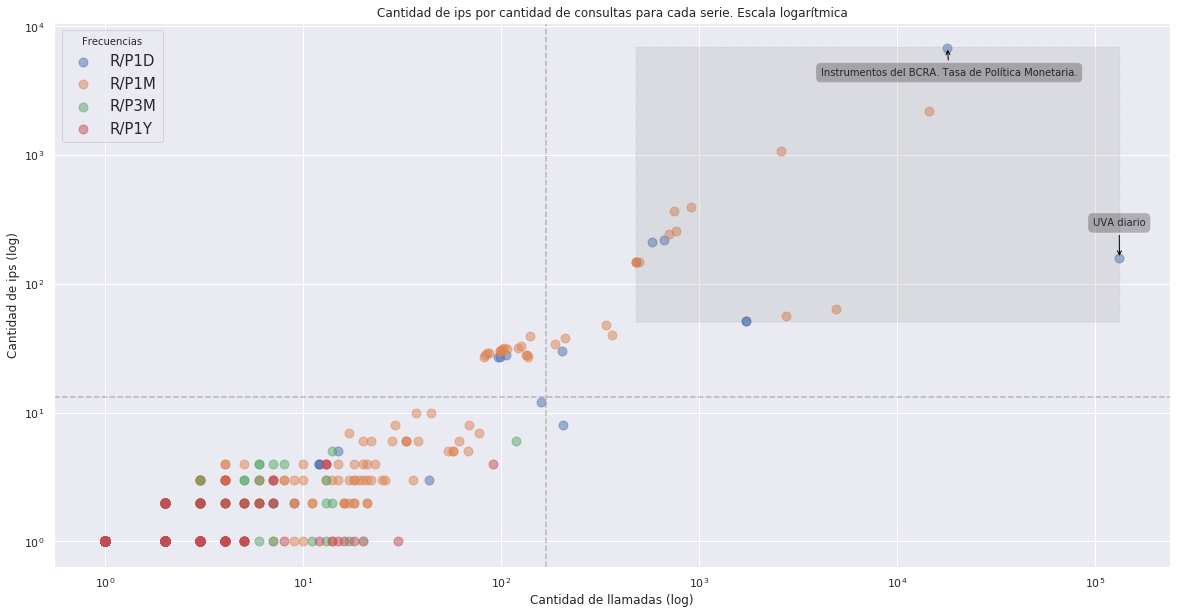

In [170]:
# fourth_quad = (X > 1000) & (Y < 200)
# fourth_quad = (X >= midpoint(X)) & (Y <= midpoint(Y))
fourth_quad = (X >= log_midpoint(X)) & (Y <= log_midpoint(Y))
fourth_quad = fourth_quad.squeeze()

second_subquad = (X >= midpoint(X)) & (Y <= midpoint(Y)) & (Y >= log_midpoint(Y))
second_subquad = second_subquad.squeeze()

forth_subquad = (X <= midpoint(X)) & (Y >= midpoint(Y)) & (X >= log_midpoint(X))
forth_subquad = forth_subquad.squeeze()

# from sklearn.kernel_ridge import KernelRidge
# clf = KernelRidge(alpha=1.0)
# clf.fit(X, Y)
# y_pred = clf.predict(X)

# plt.figure(figsize=[20,10])
fig, ax = plt.subplots(figsize=(20,10))


for frec in df_hits_ips.frecuencia.unique():
    is_frec = df_hits_ips.frecuencia.str.contains(frec)
    if is_frec.sum() > 0:
        X_frec = df_hits_ips[is_frec].consultas
        y_frec = df_hits_ips[is_frec].usuarios
#         X_frec = df_hits_ips[is_frec & (~fourth_quad)].consultas
#         y_frec = df_hits_ips[is_frec & (~fourth_quad)].ip_cantidad
        plt.scatter(X_frec, y_frec, s=80,  label=frec, alpha=.5);

        
# out_X = X[fourth_quad | second_subquad | forth_subquad].squeeze()
out_X = X[second_subquad | forth_subquad].squeeze()
# out_y = Y[fourth_quad | second_subquad | forth_subquad].squeeze()
out_y = Y[second_subquad | forth_subquad].squeeze()

out_toggler = np.array([np.where(out_X==n)[0][0]%2 for n in out_X])
out_toggler[np.where(out_toggler==0)[0]] = -1
out_toggler = -1*out_toggler

# plt.scatter(out_X, out_y, s=80,  label='outliers');
plt.legend(fontsize=15, title='Frecuencias')

# labels = df_hits_ips[fourth_quad | second_subquad | forth_subquad].serie_descripcion.values
labels = df_hits_ips[second_subquad | forth_subquad].serie_descripcion.values

for label, x, y, toggle in zip(labels, out_X, out_y, out_toggler):
    base_y = len(label) if len(label) < 47 else 10
            
    plt.annotate(
            label,
            xy=(x, y), xytext=(len(label)*5.2/2, (20+base_y)*toggle),
            textcoords='offset points', ha='right', va='bottom',
            bbox=dict(boxstyle='round,pad=0.5', fc='black', alpha=0.25),
            arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0', color='black'))

# líneas de tendencia y quadrantes.
# # plt.plot(X, y_pred*log_midpoint(y)/3, '--', color='g', alpha=0.15)
# reg = LinearRegression()
# reg.fit(X, Y)
# y_trend = reg.predict(X)
# plt.plot(X, y_trend, '--', color='g', alpha=0.25)

plt.axvline(x=np.mean(X),ymin=0, ymax=1, linestyle='--', color='grey', alpha=0.5)
plt.axhline(y=np.mean(Y),xmin=0, xmax=1, linestyle='--', color='grey', alpha=0.5)

# quadrantes a la mitad del valor de las variables
# plt.axvline(x=midpoint(X),ymin=0.5, ymax=1, linestyle='--', color='grey', alpha=0.5)
# plt.axhline(y=midpoint(Y),xmin=0.5, xmax=1, linestyle='--', color='grey', alpha=0.5)

# quadrantes a la mitad del log10 del valor de las variables
# plt.axvline(x=log_midpoint(X),ymin=0, ymax=1, linestyle='--', color='grey', alpha=0.75)
# plt.axhline(y=log_midpoint(Y),xmin=0, xmax=1, linestyle='--', color='grey', alpha=0.75)

plt.xscale('log')
plt.yscale('log')

# plt.ylim(0.1,40000)

plt.title('Cantidad de ips por cantidad de consultas para cada serie. Escala logarítmica')
plt.xlabel('Cantidad de llamadas (log)')
plt.ylabel('Cantidad de ips (log)');

# rect = patches.FancyBboxPatch((np.mean(X),np.mean(Y)), width=midpoint(X)-np.mean(X), height=midpoint(Y)-np.mean(Y)
rect = patches.FancyBboxPatch((top_rank.consultas.min(),top_rank.usuarios.min()), width=top_rank.consultas.max(), height=top_rank.usuarios.max()
                         , color='grey', linestyle='--', alpha=0.15, boxstyle='round,pad=0.5')

ax.add_patch(rect);



In [189]:
str_top_rank = put_df_on_report(top_rank_short, 'Las series del BCRA más populares')

{{str_top_rank}}

# Cantidad de llamadas 

## Perfil de las series del BCRA 

Promedio por día y por semana de las consultas a las series del BCRA:
{{df_avg_median}}


In [102]:
days_name = ['lunes','martes','miércoles','jueves','viernes','sábado','domingo']

bcra_calls_by_day_count = df_bcra_unfolded[['serie_id','date']].groupby(['date']).count()
bcra_calls_by_weekday = bcra_calls_by_day_count.groupby(pd.DatetimeIndex(bcra_calls_by_day_count.index).weekday)

bcra_calls_by_weekday_avg = bcra_calls_by_weekday.mean().reset_index()
bcra_calls_by_weekday_avg = bcra_calls_by_weekday_avg.rename(index=str, columns={"serie_id":"bcra_calls"})

no_bcra_calls_by_day_count = df_no_bcra_unfolded[['serie_id','date']].groupby(['date']).count()
no_bcra_calls_by_weekday = no_bcra_calls_by_day_count.groupby(pd.DatetimeIndex(no_bcra_calls_by_day_count.index).weekday)

no_bcra_calls_by_weekday_avg = no_bcra_calls_by_weekday.mean().reset_index()
no_bcra_calls_by_weekday_avg = no_bcra_calls_by_weekday_avg.rename(index=str, columns={"serie_id":"no_bcra_calls"})

calls_by_weekday_avg = bcra_calls_by_weekday_avg.merge(no_bcra_calls_by_weekday_avg,on='date')


calls_by_weekday_avg['day'] = days_name
calls_by_weekday_avg.set_index('day',inplace=True)

c_max = calls_by_weekday_avg['bcra_calls'].max()
c_min = calls_by_weekday_avg['bcra_calls'].mean()

c_delta = (c_max - c_min)/c_max*100
str_c_delta = f_ar(c_delta)

### Perfil de series diarias del BCRA 

A continuación se presenta el promedio de llamadas por hora y por día de la semana para las series diarias del BCRA.

Se observa que los valores son mayores para las horas de oficina, por lo que se entiende que detrás del consumo de las series hay un factor de trabajo humano ascociado.

In [103]:
bcra_calls_date_hr_count = df_bcra_unfolded[['serie_id','date', 'hour']].groupby(['date','hour']).count().reset_index()
bcra_calls_day_hour_mean = bcra_calls_date_hr_count.groupby([pd.DatetimeIndex(bcra_calls_date_hr_count.date).weekday,'hour']).mean()
bcra_calls_day_hour_mean = bcra_calls_day_hour_mean.unstack(level=-2)
bcra_calls_day_hour_mean.sort_index(ascending=False, inplace=True)

bcra_calls_day_hour_mean = bcra_calls_day_hour_mean.loc[21:7,:]

# bcra_calls_day_hour_mean.rename({0:''}, axis=1, inplace=True)


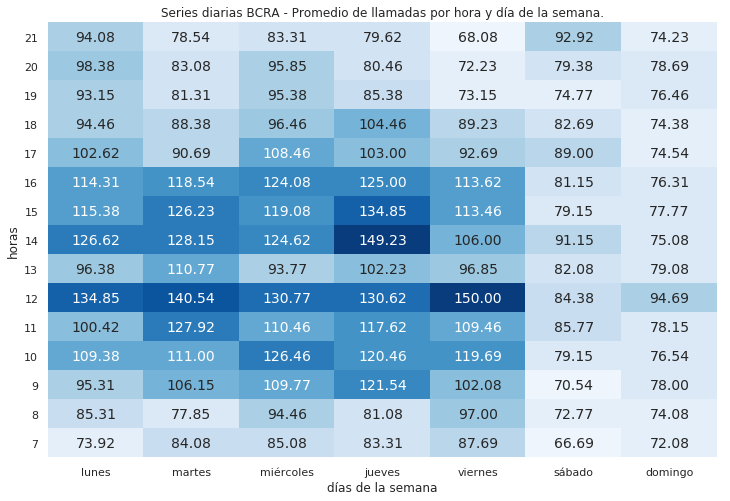

In [104]:
plt.figure(figsize=[12,8])

sns.heatmap(bcra_calls_day_hour_mean, cmap=sns.color_palette("Blues", 20), annot=True, fmt='.2f', annot_kws={'size': 14}, cbar=False);

plt.xticks(ticks=bcra_calls_day_hour_mean.columns.levels[1]+.5 ,labels=days_name)
plt.yticks(rotation='horizontal')
plt.ylabel('horas')
plt.xlabel('días de la semana')
plt.title('Series diarias BCRA - Promedio de llamadas por hora y día de la semana.');

# Cantidad de usuarios 

En esta sección se describe el comportamiento de los usuarios que consumen series del BCRA en la API Series de Tiempo.

## Comportamiento de usuarios segmentados por tipo de consumo 

Para entender el comportamiento de los usuarios, se consideran las siguientes variables:
   - _persistencia_: proporción de semanas en las que el usuario utilizó el servicio en el período considerado, y
   - _actividad_: promedio diario de consultas realizadas en el período considerado.

### Descripción de la variables

In [105]:
pd.set_option('display.float_format', lambda x: locale.format_string('%.2f', x, 1))


In [106]:
df_features = get_ip_features(df_bcra_unfolded)
df_features.describe().loc[['mean','std','min','max'],:]

,actividad,persistencia
mean,"2,80","8,41"
std,"9,48","7,56"
min,"1,00","6,25"
max,"179,96","100,00"


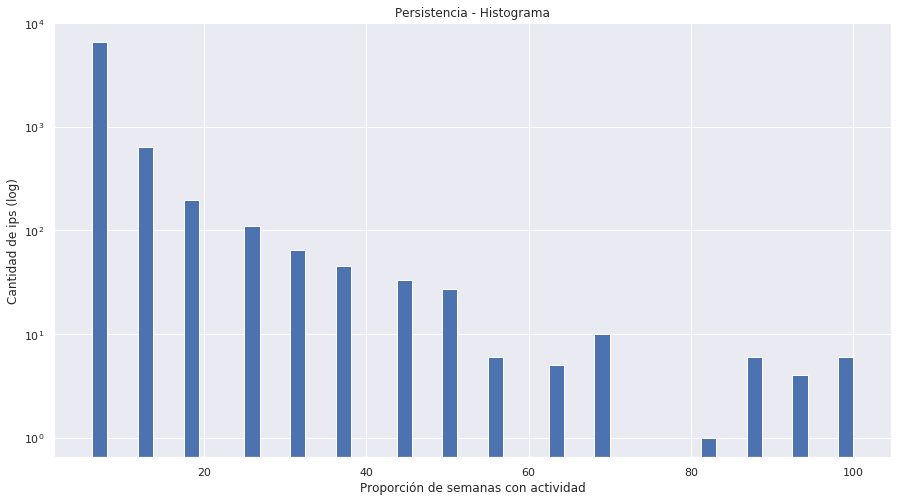

In [107]:
# get_ips_persistency(df_bcra_unfolded).hist(bins=50, figsize=[15,8])
df_features[['persistencia']].hist(bins=50, figsize=[15,8])
plt.yscale('log')
plt.title('Persistencia - Histograma')
plt.ylabel('Cantidad de ips (log)')
plt.xlabel('Proporción de semanas con actividad');

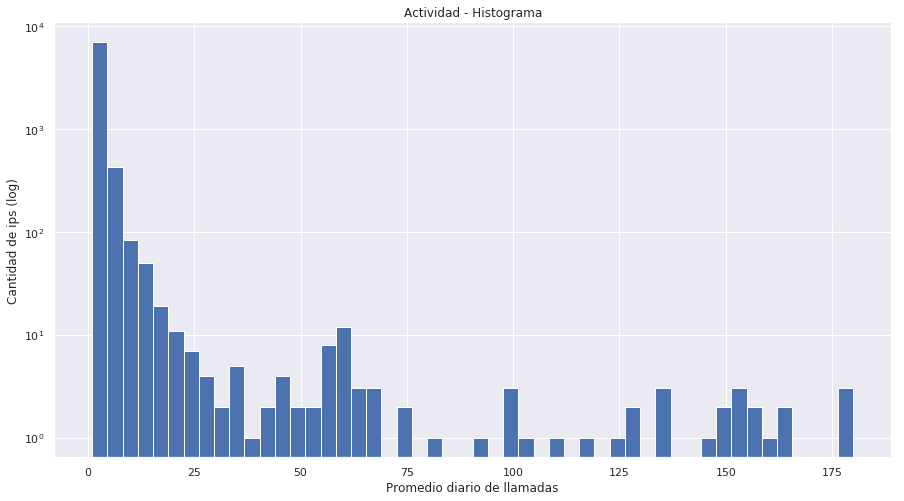

In [108]:
df_features[['actividad']].hist(bins=50, figsize=[15,8])
plt.yscale('log')
plt.title('Actividad - Histograma')
plt.ylabel('Cantidad de ips (log)')
plt.xlabel('Promedio diario de llamadas');

### Segmentación para el período completo

En los siguientes gráficos se muestran:
- Para cada usuario, la relación entre su _persistencia_ y su _actividad_, distinguiendo cuatro grupos según esas variables.
- La media de los cuatro grupos con las variables normalizadas en los ejes. El tamaño del grupo en el gráfico, refiere a la cantidad de usuarios de cada uno.
- Las propiciones de usuarios y llamadas que toma cada grupo.

Se identifican cuatro grupos de usuarios:
1. Ocasionales: Presentan niveles bajos de actividad y persistencia, y gran base de usuarios.
1. Exploratorios: Aún con baja actividad, son más persistentes que los _ocasionales_.
1. Regulares: Alcanzan niveles medios de actividad y niveles altos de persistencia. 
1. Intensivos: Se caracteriza principalmente por el alto nivel de actividad. En persistencia incluye usuarios con valores muy distintos entre sí. Es el grupo con menor cantidad de usuarios.


In [109]:
from pylab import *
import matplotlib.gridspec as gridspec

def make_cluster_plots(df_cluster, clusters):

    G = gridspec.GridSpec(4, 3)

    plt.figure(figsize=[15,20])

    axes_1 = subplot(G[0:2, :])
    plt.scatter(df_cluster['actividad'], df_cluster['persistencia'], c=df_cluster['cluster_id'], s=50,alpha=.7);
    plt.title('Segmentación de usuarios, período completo')
    plt.xlabel('actividad')
    plt.ylabel('persistencia');


    axes_3 = subplot(G[2:,:-1])
#     group_names = ['exploratorios','regulares','intensivos']
    act_std = df_cluster.actividad.std()
    pers_std = df_cluster.persistencia.std()
    act_mean = df_cluster.actividad.mean()
    pers_mean = df_cluster.persistencia.mean()

    df_cluster['actividad_norm'] = minmax_scale(df_cluster.actividad, feature_range=(act_mean-2*act_std,act_mean+2*act_std))
    df_cluster['persistencia_norm'] = minmax_scale(df_cluster.persistencia, feature_range=(pers_mean-2*pers_std,pers_mean+2*pers_std))
    
    df_cluster_profile = df_cluster.groupby(['cluster_id','cluster_name']).agg({'ip_address': pd.Series.nunique,
                                            'actividad_norm': pd.Series.mean,
                                            'persistencia_norm': pd.Series.mean}).reset_index()
#     df_cluster_profile = df_cluster_profile.astype(np.float64)
    df_cluster_profile = df_cluster_profile.sort_values('ip_address', ascending=False)
#     df_cluster_profile['cluster_name'] = pd.Series(group_names)

    with sns.axes_style('white'):
    #     fig, ax = plt.subplots(figsize=(15,10))
        axes_3.spines['bottom'].set_position('center')
        axes_3.spines['left'].set_position('center')
        axes_3.spines['bottom'].set_color('grey')
        axes_3.spines['left'].set_color('grey')
        axes_3.spines['right'].set_color('none')
        axes_3.spines['top'].set_color('none')
        axes_3.xaxis.set_label_coords(.95, 0.48)
        axes_3.yaxis.set_label_coords(0.53, 0.08)
        axes_3.set_alpha(.2)

        a = np.abs(df_cluster_profile.actividad_norm)
        p = np.abs(df_cluster_profile.persistencia_norm)
        u = df_cluster_profile.ip_address
        cluster_s = u * 1.5 * a

        df_cluster_profile.plot.scatter('actividad_norm','persistencia_norm', 
                                    c=df_cluster_profile.cluster_id.values,
#                                     c=df_cluster_profile.index.values,
                                    s=cluster_s, 
                                    cmap='Accent', 
                                    colorbar=False,
                                    alpha=.55,
                                    legend=True,
                                    ax=axes_3);

    for i, row in df_cluster_profile.iterrows():
        txt = row.cluster_name
        x = row.actividad_norm
        y = row.persistencia_norm
#         axes_3.text(df_cluster_profile.actividad_norm[id], df_cluster_profile.persistencia_norm[id], str(txt), horizontalalignment='center',verticalalignment='bottom')
        axes_3.text(x, y, txt, horizontalalignment='center',verticalalignment='bottom')

    plt.xticks([])
    plt.yticks([])

    plt.xlabel('actividad');
    plt.ylabel('persistencia');
    plt.title('Variables normalizadas.');

    ####
    # axes_2 = subplot(G[2,-1])
#     group_names = ['regulares','exploratorios','intensivos']

    df_cluster_agg = df_cluster.groupby(['cluster_id','cluster_name']).agg({'ip_address': pd.Series.nunique,
                                                           'actividad': pd.Series.sum}).reset_index()
    df_cluster_agg = df_cluster_agg.sort_values('cluster_id')
#     df_cluster_agg['cluster_name'] = pd.Series(group_names).sort_values(ascending=False)

#     for i, var in enumerate(zip(['ip_address','actividad'], ['Usuarios','Llamadas'],[subplot(G[2,-1]),subplot(G[3,-1])]), start=1):
#         col, title, axes = var
#     #     plt.subplot(1,2,i)
#         patches = df_cluster_agg[col].plot(kind='pie',autopct='%.1f',labels=None, fontsize=0, cmap='Accent', ax=axes)
#         plt.title(title)
# #         plt.ylabel('');
#         labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df_cluster_agg.cluster_name, df_cluster_agg[col].divide(df_cluster_agg[col].sum())*100)]
#         plt.legend(labels=labels, loc='best')

    col = 'ip_address'
    title = 'Usuarios'
    axes = subplot(G[2,-1])

    patches = df_cluster_agg[col].plot(kind='pie',autopct='%.1f',labels=None, fontsize=0, cmap='Accent', ax=axes)
    plt.title(title)
    plt.ylabel('');
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df_cluster_agg.cluster_name, df_cluster_agg[col].divide(df_cluster_agg[col].sum())*100)]
    plt.legend(labels=labels, loc='best')

    col = 'actividad'
    title = 'Llamadas'
    axes = subplot(G[3,-1])

    patches = df_cluster_agg[col].plot(kind='pie',autopct='%.1f',labels=None, fontsize=0, cmap='Accent', ax=axes)
    plt.title(title)
    plt.ylabel('');
    labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(df_cluster_agg.cluster_name, df_cluster_agg[col].divide(df_cluster_agg[col].sum())*100)]
    plt.legend(labels=labels, loc='best')
        
        
#     plt.suptitle('{} grupos'.format(clusters));

    # axes_4 = subplot(G[-2:,:])
    # plt.scatter(df_cluster['actividad'], df_cluster['persistencia'], c=df_cluster['cluster_id'], s=50,alpha=.7);


    plt.savefig('../graphs/graphs-{}-clusters.png'.format(clusters), dpi=64)
    plt.show()
    
    

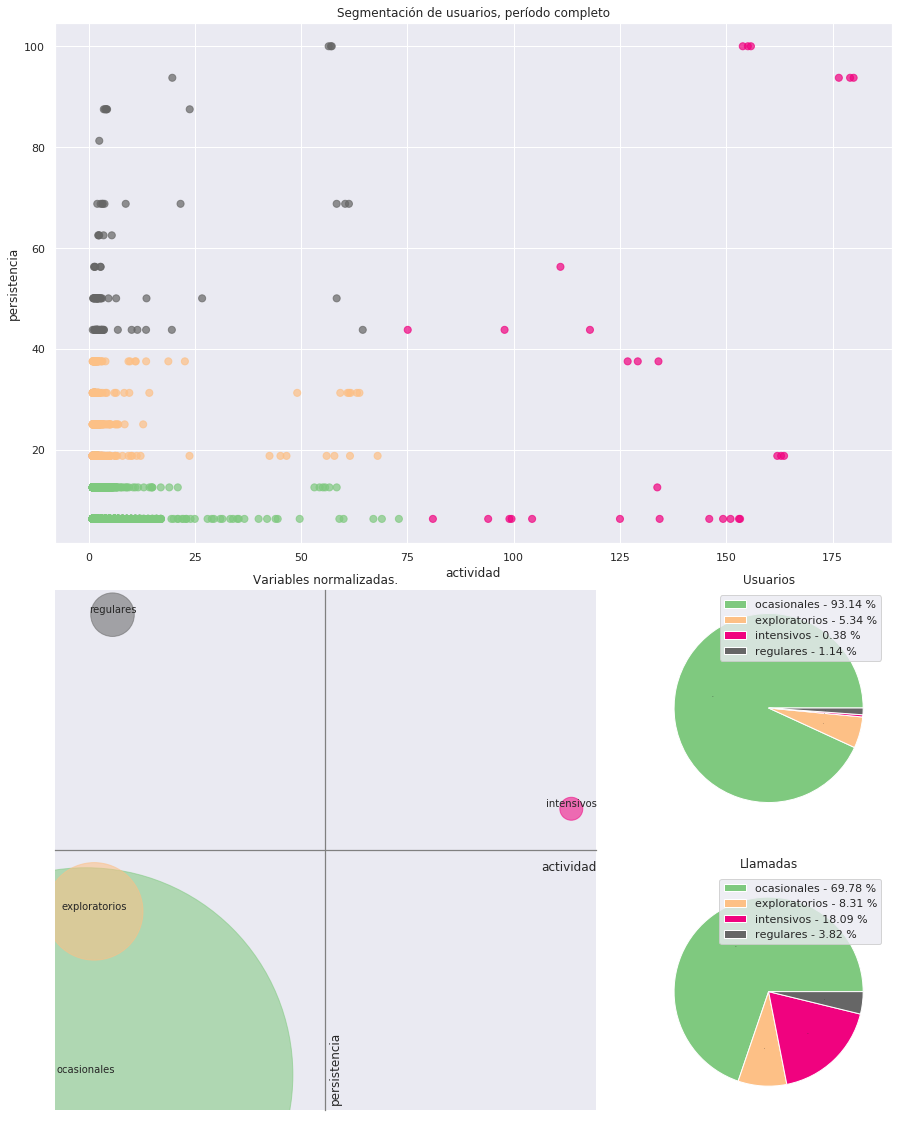

In [110]:
group_names = ['ocasionales', 'exploratorios', 'intensivos', 'regulares']

df_cluster = cluster_ips(df_bcra_unfolded, n_kmeans=4,
                         frequencies={'persistencia':'W','actividad':'D'},
                         labels= group_names)

make_cluster_plots(df_cluster, clusters=4)

In [182]:
###
# sarasa = df_unfolded_clusters.groupby(['cluster_id','ip_address']).sum().reset_index()
# # sarasa['burp'] = sarasa.series_diarias_unicas / sarasa.series_unicas * 100

# sarasa = sarasa.groupby('cluster_id').mean().sort_values('actividad', ascending=False)

# sarasa['burp'] = sarasa.series_diarias_unicas / sarasa.series_unicas * 100

# sarasa;

In [112]:
df_unfolded_clusters = df_bcra_unfolded[['ip_address','serie_id','indice_tiempo_frecuencia']].merge(df_cluster, on='ip_address')

serie_diaria = df_unfolded_clusters.indice_tiempo_frecuencia.str.contains('R/P1D')

# df_id_unicas_por_cluster = df_unfolded_clusters.groupby('cluster_id').nunique()['serie_id'].reset_index()
# df_id_diarias_unicas_por_cluster = df_unfolded_clusters[serie_diaria].groupby('cluster_id').nunique()['serie_id'].reset_index()

df_id_unicas_por_cluster = df_unfolded_clusters.groupby('cluster_id').nunique()['serie_id'].reset_index()
# df_id_unicas_por_cluster = df_id_unicas_por_cluster.groupby

df_id_diarias_unicas_por_cluster = df_unfolded_clusters[serie_diaria].groupby('cluster_id').nunique()['serie_id'].reset_index()

addd = df_id_unicas_por_cluster.merge(df_id_diarias_unicas_por_cluster, on='cluster_id')
addd['proporcion_series_diarias'] = addd.serie_id_y / addd.serie_id_x * 100


In [113]:
df_series_avg = get_nunique_series_avg(df_bcra_unfolded, frequency='D')
df_cluster = df_cluster.merge(df_series_avg, how='inner', on='ip_address')

df_cluster_profile = df_cluster.groupby(['cluster_id','cluster_name']).agg({'ip_address': pd.Series.nunique,
                                        'actividad': pd.Series.mean,
                                        'persistencia': pd.Series.mean,
#                                         'series_unicas_diarias': pd.Series.mean,
#                                         'series_unicas_semanales': pd.Series.mean,
                                        'series_unicas_mensuales': pd.Series.mean,
#                                         'series_unicas': pd.Series.sum,
#                                         'series_diarias_unicas': pd.Series.sum
                                                                           }).reset_index()


# df_cluster_profile['proporcion_series_diarias'] = df_cluster_profile.series_diarias_unicas / df_cluster_profile.series_unicas * 100
# df_cluster_profile.drop(columns=['series_unicas','series_diarias_unicas'], inplace=True)

df_cluster_profile = df_cluster_profile.sort_values('actividad',ascending=False).reset_index(drop=True)
df_cluster_profile.rename({'ip_address':'usuarios', 'cluster_name':'grupo'}, axis=1, inplace=True)

for c in df_cluster_profile.columns[2:].values:
    df_cluster_profile[c] = df_cluster_profile[c].apply(lambda x: locale.format_string('%.2f', x, 1))

df_cluster_profile = df_cluster_profile.merge(addd[['cluster_id','proporcion_series_diarias']], on='cluster_id')
# df_cluster_profile = df_cluster_profile.merge(addd, on='cluster_id')

En el perfil de los grupos se incluye el promedio mensual de la cantidad de series distintas que consultan (*series_unicas_mensuales*) y la proporción de series diarias en el total de series únicas consultadas (*proporcion_series_diaras*).

In [149]:
str_df_cluster_profile = put_df_on_report(df_cluster_profile.iloc[:,1:], 'Perfil de los grupos')

{{str_df_cluster_profile}}